# Data loading

In [166]:
import pandas as pd
raw_datas = pd.read_csv("./datas/train.csv").dropna()

# Feature extraction

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(raw_datas["text"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## W2V weighted by tf-idf

In [168]:
from gensim.sklearn_api import W2VTransformer

vector_size = 300

w2v_model = W2VTransformer(size=vector_size, min_count=1).fit([re.findall(r"(?u)\b\w\w+\b", doc) for doc in raw_datas["text"]])

In [169]:
import re
import math
import numpy as np

weights = tfidf_vectorizer.idf_
weights_dict = dict(zip(tfidf_vectorizer.get_feature_names(), weights))

def get_vector(word: str) -> np.array:
    try:
        #vector = fasttext_model[word]
        vector = w2v_model.transform(word)
        return vector[0]
    except Exception:
        return np.random.randn(vector_size)

def w2v_extract_features():
    drops = 0
    X = np.zeros([len(raw_datas["text"]), vector_size])
    for i, doc in enumerate(raw_datas["text"]):
        tokens = [token.lower() for token in re.findall(r"(?u)\b\w\w+\b", doc)]
        if len(tokens) == 0:
            drops += 1
            continue
        exp_weights_sum = sum([math.exp(weights_dict.get(token, 0)) for token in tokens])
        vectors = np.array([get_vector(token) for token in tokens])
        vectors_weights = np.expand_dims(np.array([weights_dict.get(token, 1) / len(tokens) for token in tokens]), axis=1)
        X[i] = np.sum(vectors_weights * vectors, axis=0)

    print(f"dropped {drops} texts")

    return X

## tf-idf

In [170]:
def tfidf_extract_features():
    X = tfidf_vectorizer.transform(raw_datas["text"])
    return X

# Tests

In [171]:
features = [w2v_extract_features(), tfidf_extract_features()]

dropped 71 texts


/home/aethor/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/aethor/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/aethor/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


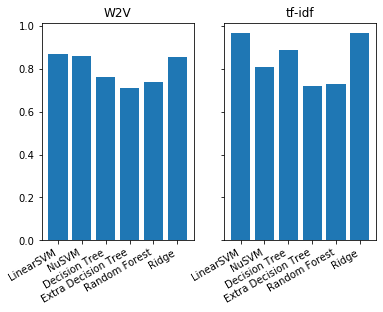

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

class ClassifierTest:
    def __init__(self, name: str, classifier):
        self.name = name
        self.classifier = classifier
        self.result = 0

    def fit(self, X, y):
        self.classifier.fit(X, y)

    def score(self, X, y):
        self.result = self.classifier.score(X, y)


y = raw_datas["label"]

classifier_tests = [
    ClassifierTest("LinearSVM", LinearSVC()),
    ClassifierTest("NuSVM", NuSVC()),
    ClassifierTest("Decision Tree", DecisionTreeClassifier()),
    ClassifierTest("Extra Decision Tree", ExtraTreeClassifier()),
    ClassifierTest("Random Forest", ExtraTreeClassifier()),
    ClassifierTest("Ridge", RidgeClassifier()),
]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
axes = (ax1, ax2)
ax1.set_title("W2V")
ax2.set_title("tf-idf")

for i, X in enumerate(features):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for classifier_test in classifier_tests:
        classifier_test.fit(X_train, y_train)
        classifier_test.score(X_test, y_test)

    axes[i].set_xticks(list(range(len(classifier_tests))))
    axes[i].set_xticklabels([c.name for c in classifier_tests])
    plt.setp(axes[i].get_xticklabels(), rotation=30, horizontalalignment='right')
    axes[i].bar(
        list(range(len(classifier_tests))),
        [c.result for c in classifier_tests]
    )
    

plt.show()